### Loading the data

In [112]:

import pandas as pd
import numpy as np
import json
import ast
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw
from scipy.stats import linregress

COLORS = {
    'prey': '#2ecc71',      # Green
    'predator': '#e74c3c',  # Red
}

# Seaborn style
sns.set_theme(style="whitegrid", context="notebook")
sns.set_palette([COLORS['prey'], COLORS['predator']])

plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# =============================================================================
# Configuration
# =============================================================================

JOB_NUMBERS = {
    1: 18677015,
    1.5: 18682575,  # If this is a variant of phase 1
    2: 18693004,
    3: 18698382,
    4: 18735304,
}

BASE_DATA_DIR = Path("../hpc_data")
BASE_RESULTS_DIR = Path("../results")

# =============================================================================
# Loading Functions
# =============================================================================

def load_jsonl(filepath):
    """Load JSONL file into DataFrame."""
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                print(f"Skipping invalid line: {line[:50]}...")
    return pd.DataFrame(data)


def load_metadata(filepath):
    """Load JSON metadata file."""
    with open(filepath, 'r') as f:
        return json.load(f)


def parse_list_column(x):
    """Parse string representations of lists."""
    if isinstance(x, list):
        return x
    if pd.isna(x) or x == '[]':
        return []
    try:
        return ast.literal_eval(x)
    except:
        return []


def load_phase(phase, job_number: int = None) -> tuple[pd.DataFrame, dict]:
    """
    Load results and metadata for a given phase.
    
    Args:
        phase: Phase number (1, 1.5, 2, 3, etc.)
        job_number: Override job number if needed
    
    Returns:
        df: DataFrame with results
        meta: dict with metadata
    """
    if job_number is None:
        job_number = JOB_NUMBERS.get(phase)
    if job_number is None:
        raise ValueError(f"No job number specified for phase {phase}")
    
    # Construct paths - handle phase 1.5 writing to phase1_results.jsonl
    phase_dir = BASE_DATA_DIR / f"phase{phase}_{job_number}"
    
    # Determine the actual results filename (phase 1.5 uses phase1_results.jsonl)
    phase_int = int(phase)
    results_file = phase_dir / f"phase{phase_int}_results.jsonl"
    metadata_file = phase_dir / f"phase{phase_int}_metadata.json"
    
    if not results_file.exists():
        raise FileNotFoundError(f"Results file not found: {results_file}")
    
    df = load_jsonl(results_file)
    meta = load_metadata(metadata_file) if metadata_file.exists() else {}
    
    # Parse cluster columns
    if 'prey_cluster_sizes' in df.columns:
        df['prey_clusters_parsed'] = df['prey_cluster_sizes'].apply(parse_list_column)
    if 'pred_cluster_sizes' in df.columns:
        df['pred_clusters_parsed'] = df['pred_cluster_sizes'].apply(parse_list_column)
    
    # Parse timeseries columns
    for col in ['prey_timeseries', 'pred_timeseries', 'evolved_prey_death_timeseries']:
        if col in df.columns:
            df[f'{col}_parsed'] = df[col].apply(parse_list_column)
    
    print(f"Phase {phase}: Loaded {len(df)} runs from job {job_number}")
    return df, meta


def setup_results_dir(phase, job_number: int = None) -> Path:
    """Create and return results directory for a phase."""
    if job_number is None:
        job_number = JOB_NUMBERS.get(phase)
    results_dir = BASE_RESULTS_DIR / f"phase{phase}_{job_number}"
    results_dir.mkdir(parents=True, exist_ok=True)
    return results_dir

### Phase 1

In [92]:
df1, meta1 = load_phase(1)
results_dir1 = setup_results_dir(1)

Phase 1: Loaded 600 runs from job 18677015
Phase 3: Loaded 120 runs from job 18698382


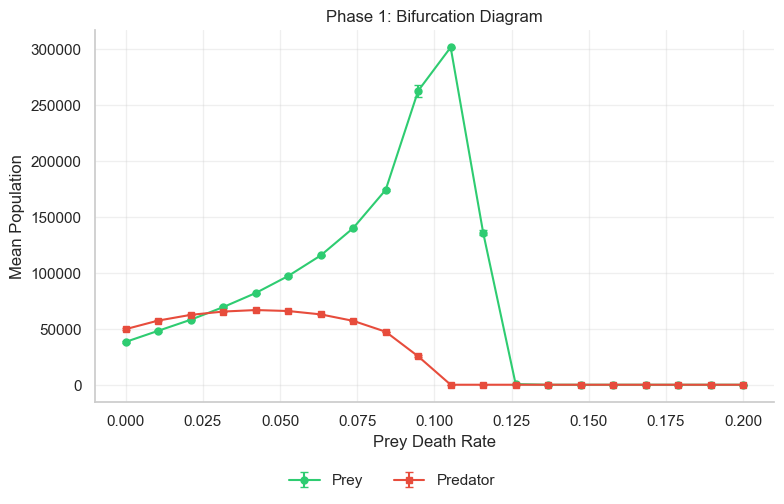

In [93]:
fig, ax = plt.subplots(figsize=(8, 5))

# Aggregate by prey_death
agg = df1.groupby('prey_death').agg(
    prey_mean=('prey_mean', 'mean'),
    prey_std=('prey_mean', 'std'),
    pred_mean=('pred_mean', 'mean'),
    pred_std=('pred_mean', 'std'),
).reset_index()

# Plot prey
ax.errorbar(
    agg['prey_death'], agg['prey_mean'], yerr=agg['prey_std'],
    fmt='o-', capsize=3, color=COLORS['prey'], markersize=5, label='Prey'
)

# Plot predator
ax.errorbar(
    agg['prey_death'], agg['pred_mean'], yerr=agg['pred_std'],
    fmt='s-', capsize=3, color=COLORS['predator'], markersize=5, label='Predator'
)

ax.set_xlabel('Prey Death Rate')
ax.set_ylabel('Mean Population')
ax.set_title('Phase 1: Bifurcation Diagram')

# Legend at bottom
fig.legend(
    loc='lower center', 
    ncol=2, 
    bbox_to_anchor=(0.5, -0.02),
    frameon=False
)

plt.tight_layout()
fig.subplots_adjust(bottom=0.18)
plt.show()


In [94]:
# Phase 1.5 if needed
df1_5, meta1_5 = load_phase(1.5)
results_dir1_5 = setup_results_dir(1.5)

Phase 1.5: Loaded 600 runs from job 18682575


In [95]:
# Find Critical Point
# Aggregate by prey_death
agg = df1_5.groupby('prey_death').agg(
    prey_mean=('prey_mean', 'mean'),
    prey_std=('prey_mean', 'std'),
    pred_survived=('pred_survived', 'mean'),
).reset_index()

# Critical point: peak prey population (Hydra effect maximum)
critical_idx = agg['prey_mean'].idxmax()
critical_prey_death = agg.loc[critical_idx, 'prey_death']
critical_prey_pop = agg.loc[critical_idx, 'prey_mean']

print(f"\n{'='*60}")
print("CRITICAL POINT IDENTIFICATION")
print(f"{'='*60}")
print(f"Critical prey death rate: {critical_prey_death:.4f}")
print(f"Peak prey population: {critical_prey_pop:,.0f}")
print(f"Predator survival at critical point: {agg.loc[critical_idx, 'pred_survived']:.1%}")



CRITICAL POINT IDENTIFICATION
Critical prey death rate: 0.0995
Peak prey population: 351,272
Predator survival at critical point: 100.0%


In [96]:
# Extract cluster sizes

 # Get runs at or near critical point
tolerance = 0.001  # Allow small tolerance for floating point #NOTE: This can be increased
critical_runs = df1_5[np.abs(df1_5['prey_death'] - critical_prey_death) < tolerance]

print(f"\nRuns at critical point: {len(critical_runs)}")

# Aggregate all cluster sizes
prey_clusters_critical = []
pred_clusters_critical = []

for _, row in critical_runs.iterrows():
    prey_clusters_critical.extend(row['prey_clusters_parsed'])
    pred_clusters_critical.extend(row['pred_clusters_parsed'])

prey_clusters_critical = np.array([s for s in prey_clusters_critical if s > 0])
pred_clusters_critical = np.array([s for s in pred_clusters_critical if s > 0])

print(f"Total prey clusters: {len(prey_clusters_critical)}")
print(f"Total predator clusters: {len(pred_clusters_critical)}")


Runs at critical point: 30
Total prey clusters: 439310
Total predator clusters: 23745


In [97]:
# Power law fit
def fit_powerlaw(data, name):
    """Fit power law and truncated power law, report statistics."""
    print(f"\n{'-'*60}")
    print(f"{name.upper()} CLUSTER SIZE DISTRIBUTION")
    print(f"{'-'*60}")
    
    fit = powerlaw.Fit(data, discrete=True, verbose=False)
    
    print(f"\nPure Power Law:")
    print(f" alpha (exponent): {fit.power_law.alpha:.3f} ± {fit.power_law.sigma:.3f}")
    print(f"  x_min: {fit.power_law.xmin}")
    print(f"  D (KS statistic): {fit.power_law.D:.4f}")
    
    print(f"\nTruncated Power Law:")
    print(f"  alpha (exponent): {fit.truncated_power_law.alpha:.3f}")
    print(f"  lambda (cutoff rate): {fit.truncated_power_law.parameter2:.6f}")
    print(f"  x_min: {fit.truncated_power_law.xmin}")
    
    R, p = fit.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
    print(f"\nModel Comparison (Power Law vs Truncated Power Law):")
    print(f"  Log-likelihood ratio R: {R:.3f}")
    print(f"  p-value: {p:.4f}")
    if R > 0:
        print(f"Pure power law preferred (R > 0)")
    else:
        print(f"Truncated power law preferred (R < 0)")
    if p < 0.05:
        print(f"Difference is statistically significant (p < 0.05)")
    else:
        print(f"Difference is NOT statistically significant (p ≥ 0.05)")
    
    return fit, R, p

In [98]:
def compute_ccdf(data):
    """Compute empirical CCDF."""
    sorted_data = np.sort(data)
    ccdf = 1 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ccdf


prey_fit, prey_R, prey_p = fit_powerlaw(prey_clusters_critical, "Prey")
pred_fit, pred_R, pred_p = fit_powerlaw(pred_clusters_critical, "Predator")


------------------------------------------------------------
PREY CLUSTER SIZE DISTRIBUTION
------------------------------------------------------------

Pure Power Law:
 alpha (exponent): 1.730 ± 0.002
  x_min: 7.0
  D (KS statistic): 0.0261

Truncated Power Law:


/Users/kimonanagnostopoulos/CSS_Project/.venv/lib/python3.12/site-packages/powerlaw/distributions.py:808: UserWarning: Fitted parameters are very close to the edge of parameter ranges for distribution truncated_power_law; consider changing these ranges.
  warnings.warn(f'Fitted parameters are very close to the edge of parameter ranges for distribution {self.name}; consider changing these ranges.')
/Users/kimonanagnostopoulos/CSS_Project/.venv/lib/python3.12/site-packages/powerlaw/distributions.py:743: OptimizeWarning: Initial guess is not within the specified bounds
  result = scipy.optimize.minimize(fit_function,


  alpha (exponent): 1.622
  lambda (cutoff rate): 0.000501
  x_min: 7.0

Model Comparison (Power Law vs Truncated Power Law):
  Log-likelihood ratio R: -43.129
  p-value: 0.0000
Truncated power law preferred (R < 0)
Difference is statistically significant (p < 0.05)

------------------------------------------------------------
PREDATOR CLUSTER SIZE DISTRIBUTION
------------------------------------------------------------

Pure Power Law:
 alpha (exponent): 2.888 ± 0.028
  x_min: 5.0
  D (KS statistic): 0.0765

Truncated Power Law:
  alpha (exponent): 0.645
  lambda (cutoff rate): 0.194558
  x_min: 5.0

Model Comparison (Power Law vs Truncated Power Law):
  Log-likelihood ratio R: -12.924
  p-value: 0.0000
Truncated power law preferred (R < 0)
Difference is statistically significant (p < 0.05)


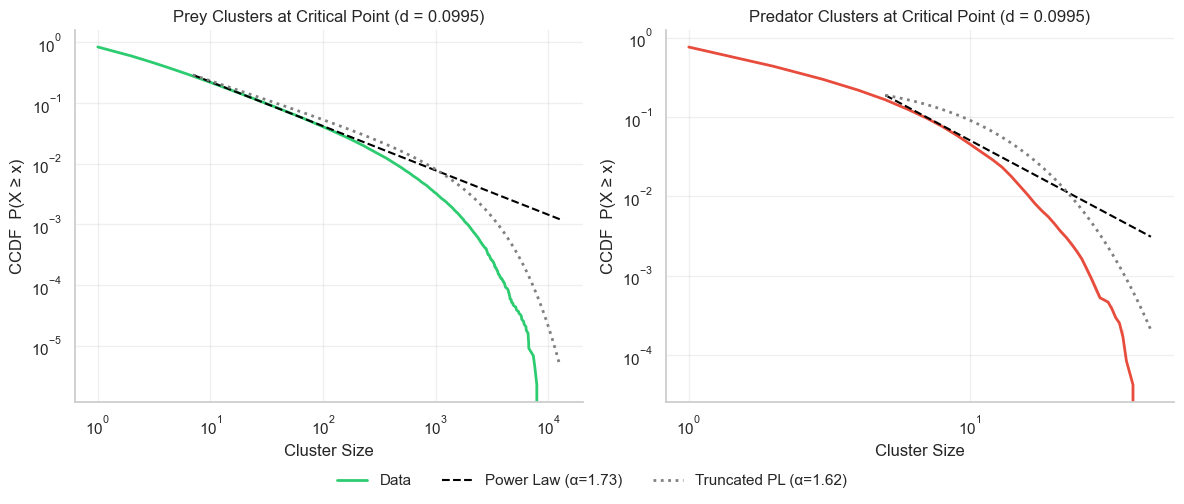

In [99]:
# Plot: Cluster Size Distributions with Fits

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, fit, data, name, color in [
    (axes[0], prey_fit, prey_clusters_critical, 'Prey', COLORS['prey']),
    (axes[1], pred_fit, pred_clusters_critical, 'Predator', COLORS['predator']),
]:
    # Compute empirical CCDF
    x_data, y_data = compute_ccdf(data)
    
    # Create DataFrame for seaborn
    df_ccdf = pd.DataFrame({'Cluster Size': x_data, 'CCDF': y_data})
    
    # Plot empirical data
    sns.lineplot(data=df_ccdf, x='Cluster Size', y='CCDF', ax=ax, 
                 color=color, linewidth=2, label='Data')
    
    # Generate theoretical fits
    x_fit = np.logspace(np.log10(fit.xmin), np.log10(data.max()), 100)
    
    # Power law CCDF: P(X >= x) = (x/xmin)^(-alpha+1)
    y_pl = (x_fit / fit.power_law.xmin) ** (-fit.power_law.alpha + 1)
    y_pl *= (data >= fit.power_law.xmin).sum() / len(data)  # Scale to data
    
    # Truncated power law (approximate CCDF)
    alpha_t = fit.truncated_power_law.alpha
    lam = fit.truncated_power_law.parameter2
    y_tpl = (x_fit / fit.truncated_power_law.xmin) ** (-alpha_t + 1) * np.exp(-lam * (x_fit - fit.truncated_power_law.xmin))
    y_tpl *= (data >= fit.truncated_power_law.xmin).sum() / len(data)
    
    # Plot fits
    sns.lineplot(x=x_fit, y=y_pl, ax=ax, color='black', linestyle='--', 
                 linewidth=1.5, label=f'Power Law (α={fit.power_law.alpha:.2f})')
    sns.lineplot(x=x_fit, y=y_tpl, ax=ax, color='gray', linestyle=':', 
                 linewidth=2, label=f'Truncated PL (α={fit.truncated_power_law.alpha:.2f})')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Cluster Size')
    ax.set_ylabel('CCDF  P(X ≥ x)')
    ax.set_title(f'{name} Clusters at Critical Point (d = {critical_prey_death:.4f})')
    ax.get_legend().remove()
    
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02), frameon=False)

plt.tight_layout()
fig.subplots_adjust(bottom=0.18)
plt.show()


In [100]:
print(f"\n{'='*60}")
print("SUMMARY")
print(f"{'='*60}")
print(f"Critical prey death rate: {critical_prey_death:.4f}")
print(f"\nPrey clusters:")
print(f"  Exponent α = {prey_fit.power_law.alpha:.3f} ± {prey_fit.power_law.sigma:.3f}")
print(f"  Truncated PL preferred: {prey_R < 0} (p = {prey_p:.4f})")
print(f"\nPredator clusters:")
print(f"  Exponent α = {pred_fit.power_law.alpha:.3f} ± {pred_fit.power_law.sigma:.3f}")
print(f"  Truncated PL preferred: {pred_R < 0} (p = {pred_p:.4f})")


SUMMARY
Critical prey death rate: 0.0995

Prey clusters:
  Exponent α = 1.730 ± 0.002
  Truncated PL preferred: True (p = 0.0000)

Predator clusters:
  Exponent α = 2.888 ± 0.028
  Truncated PL preferred: True (p = 0.0000)


In [101]:
# =============================================================================
# Select Three Points: Before, At, After Critical
# =============================================================================

prey_death_values = sorted(df1_5['prey_death'].unique())
critical_index = prey_death_values.index(critical_prey_death)

# Select points: ~2-3 steps before and after critical
step = max(1, len(prey_death_values) // 10)  # Adaptive step size
before_idx = max(0, critical_index - step)
after_idx = min(len(prey_death_values) - 1, critical_index + step)

selected_deaths = [
    prey_death_values[before_idx],
    critical_prey_death,
    prey_death_values[after_idx],
]

labels = ['Before Critical', 'At Critical', 'After Critical']
palette = ['#3498db', '#9b59b6', '#e67e22']  # Blue, Purple, Orange

print(f"\nSelected prey death rates:")
for label, d in zip(labels, selected_deaths):
    print(f"  {label}: d = {d:.4f}")


Selected prey death rates:
  Before Critical: d = 0.0963
  At Critical: d = 0.0995
  After Critical: d = 0.1026


In [102]:
def get_clusters_at_death_rate(df, death_rate, tolerance=0.001):
    """Extract all cluster sizes at a given prey death rate."""
    runs = df[np.abs(df['prey_death'] - death_rate) < tolerance]
    
    prey_clusters = []
    pred_clusters = []
    
    for _, row in runs.iterrows():
        prey_clusters.extend(row['prey_clusters_parsed'])
        pred_clusters.extend(row['pred_clusters_parsed'])
    
    prey_clusters = np.array([s for s in prey_clusters if s > 0])
    pred_clusters = np.array([s for s in pred_clusters if s > 0])
    
    return prey_clusters, pred_clusters


def compute_frequency_distribution(data):
    """Compute frequency distribution for scatter plot."""
    sizes, counts = np.unique(data, return_counts=True)
    return sizes, counts

In [103]:
# Collect data for all three points
cluster_data = []

for death_rate, label, color in zip(selected_deaths, labels, palette):
    prey_clusters, pred_clusters = get_clusters_at_death_rate(df1_5, death_rate)
    
    # Prey frequency distribution
    if len(prey_clusters) > 0:
        sizes, counts = compute_frequency_distribution(prey_clusters)
        for s, c in zip(sizes, counts):
            cluster_data.append({
                'Cluster Size': s,
                'Frequency': c,
                'Regime': label,
                'Species': 'Prey',
                'prey_death': death_rate,
            })
            
    # Predator frequency distribution
    if len(pred_clusters) > 0:
        sizes, counts = compute_frequency_distribution(pred_clusters)
        for s, c in zip(sizes, counts):
            cluster_data.append({
                'Cluster Size': s,
                'Frequency': c,
                'Regime': label,
                'Species': 'Predator',
                'prey_death': death_rate,
            })

df_clusters = pd.DataFrame(cluster_data)


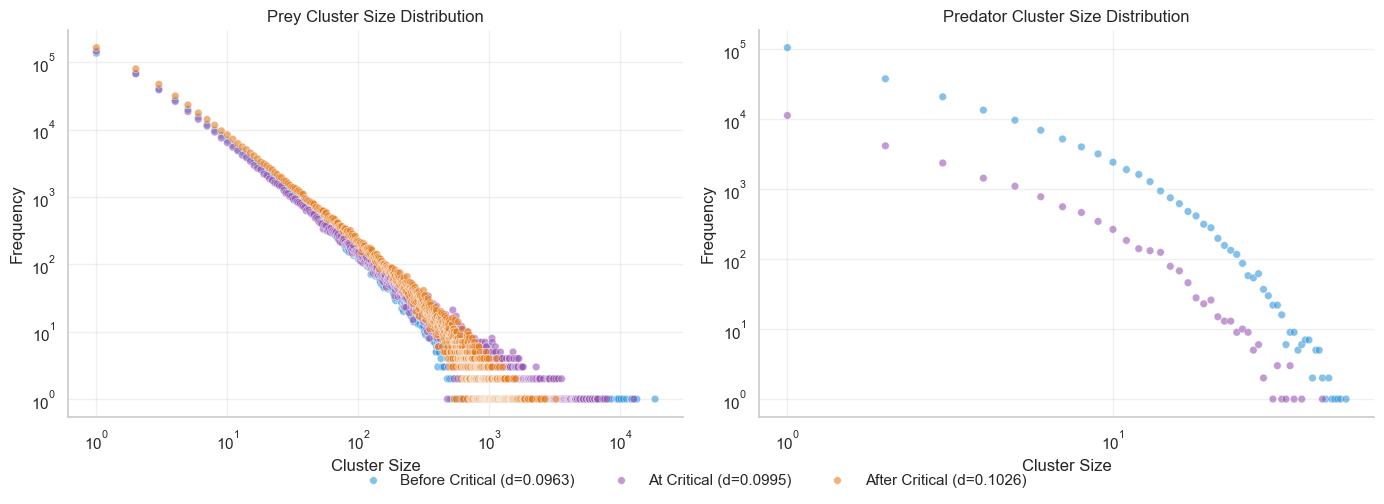

In [104]:
# =============================================================================
# Plot: Scatter Plot of Cluster Size Distributions
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, species, base_color in zip(axes, ['Prey', 'Predator'], [COLORS['prey'], COLORS['predator']]):
    
    df_species = df_clusters[df_clusters['Species'] == species]
    
    sns.scatterplot(
        data=df_species,
        x='Cluster Size',
        y='Frequency',
        hue='Regime',
        hue_order=labels,
        palette=palette,
        alpha=0.6,
        s=30,
        ax=ax,
    )
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Cluster Size')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{species} Cluster Size Distribution')
    ax.get_legend().remove()

# Shared legend at bottom
handles, legend_labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, 
    [f'{l} (d={d:.4f})' for l, d in zip(labels, selected_deaths)],
    loc='lower center', 
    ncol=3, 
    bbox_to_anchor=(0.5, -0.02), 
    frameon=False
)

plt.tight_layout()
fig.subplots_adjust(bottom=0.15)
plt.show()


### Phase 2

In [105]:
df2, meta2 = load_phase(2)
results_dir2 = setup_results_dir(2)

Phase 2: Loaded 200 runs from job 18693004


In [106]:
critical_prey_death = 0.0963
agg2 = df2.groupby('prey_death').agg(
    evolved_final_mean=('evolved_prey_death_final', 'mean'),
    evolved_final_std=('evolved_prey_death_final', 'std'),
    evolved_final_se=('evolved_prey_death_final', lambda x: x.std() / np.sqrt(len(x))),
    n_runs=('evolved_prey_death_final', 'count'),
).reset_index()
print(f"Initial prey_death range: [{df2['prey_death'].min():.4f}, {df2['prey_death'].max():.4f}]")
print(f"Final evolved range: [{df2['evolved_prey_death_final'].min():.4f}, {df2['evolved_prey_death_final'].max():.4f}]")
print(f"Critical point (Phase 1): {critical_prey_death:.4f}")

Initial prey_death range: [0.0000, 0.2000]
Final evolved range: [0.0000, 0.0713]
Critical point (Phase 1): 0.0963


### Phase 3

In [107]:
df3, meta3 = load_phase(3)
results_dir3 = setup_results_dir(3)

Phase 3: Loaded 120 runs from job 18698382


In [108]:
print(f"Grid sizes: {sorted(df3['grid_size'].unique())}")
print(f"Runs per grid size: {df3.groupby('grid_size').size().to_dict()}")
print(f"Critical point: prey_birth={meta3['critical_point']['prey_birth']}, prey_death={meta3['critical_point']['prey_death']}")


Grid sizes: [np.int64(50), np.int64(100), np.int64(250), np.int64(500), np.int64(1000), np.int64(2500)]
Runs per grid size: {50: 20, 100: 20, 250: 20, 500: 20, 1000: 20, 2500: 20}
Critical point: prey_birth=0.2, prey_death=0.0963


In [109]:
# =============================================================================
# Extract Cluster Sizes by Grid Size
# =============================================================================

grid_sizes = sorted(df3['grid_size'].unique())

cluster_data = {}
for L in grid_sizes:
    subset = df3[df3['grid_size'] == L]
    
    prey_clusters = []
    pred_clusters = []
    
    for _, row in subset.iterrows():
        prey_clusters.extend(row['prey_clusters_parsed'])
        pred_clusters.extend(row['pred_clusters_parsed'])
    
    cluster_data[L] = {
        'prey': np.array([s for s in prey_clusters if s > 0]),
        'pred': np.array([s for s in pred_clusters if s > 0]),
    }
    
    print(f"L={L}: {len(cluster_data[L]['prey']):,} prey clusters, {len(cluster_data[L]['pred']):,} pred clusters")


L=50: 555 prey clusters, 31 pred clusters
L=100: 2,670 prey clusters, 785 pred clusters
L=250: 18,109 prey clusters, 8,894 pred clusters
L=500: 73,950 prey clusters, 37,118 pred clusters
L=1000: 293,858 prey clusters, 144,104 pred clusters
L=2500: 1,832,664 prey clusters, 901,158 pred clusters


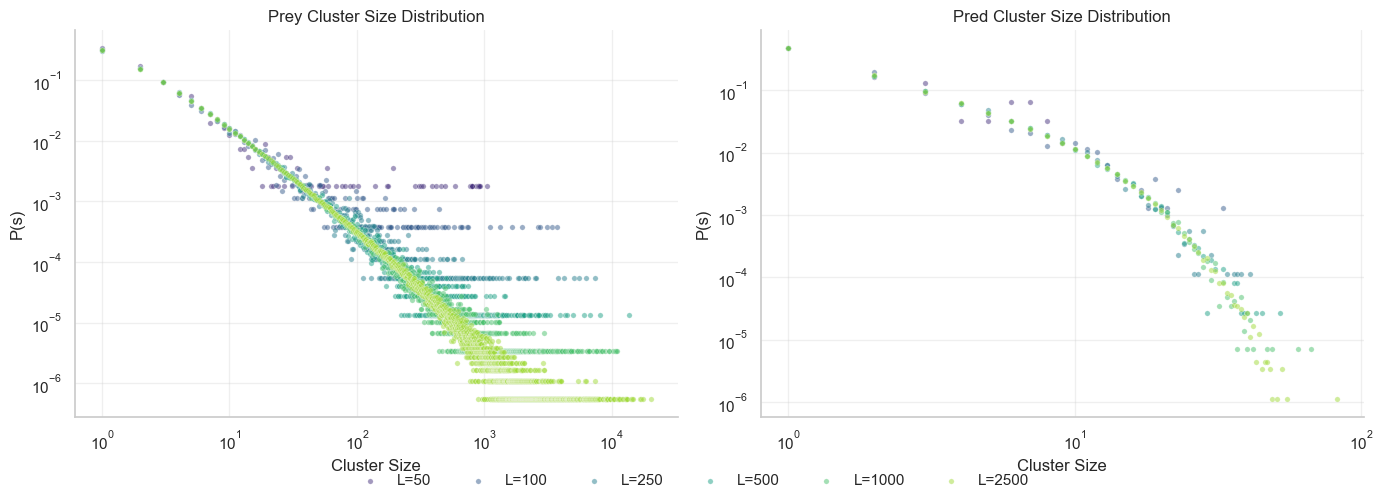

In [110]:
# Plot 1: Cluster Size Distributions by Grid Size

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Color palette for grid sizes
palette = sns.color_palette("viridis", len(grid_sizes))

for ax, species in zip(axes, ['prey', 'pred']):
    for L, color in zip(grid_sizes, palette):
        data = cluster_data[L][species]
        if len(data) > 0:
            # Compute frequency distribution
            sizes, counts = np.unique(data, return_counts=True)
            
            # Normalize to PDF
            pdf = counts / counts.sum()
            
            sns.scatterplot(x=sizes, y=pdf, color=color, alpha=0.5, s=15, 
                           label=f'L={L}', ax=ax)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Cluster Size')
    ax.set_ylabel('P(s)')
    ax.set_title(f'{species.capitalize()} Cluster Size Distribution')
    ax.legend().remove()

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(grid_sizes), 
           bbox_to_anchor=(0.5, -0.02), frameon=False)

plt.tight_layout()
fig.subplots_adjust(bottom=0.15)
plt.show()

### Phase 4

In [115]:
df4, meta4 = load_phase(4)
df4.head()

Phase 4: Loaded 146410 runs from job 18735304


,prey_birth,prey_death,predator_birth,predator_death,grid_size,with_evolution,seed,prey_mean,prey_std,pred_mean,...,prey_cluster_sizes,pred_cluster_sizes,prey_largest_fraction,pred_largest_fraction,prey_timeseries,pred_timeseries,prey_clusters_parsed,pred_clusters_parsed,prey_timeseries_parsed,pred_timeseries_parsed
0,0.0,0.0,0.0,0.0,250,False,2823796863,18750.0,0.0,9375.0,...,"[134, 124, 114, 112, 108, 106, 105, 103, 96, 9...","[20, 19, 17, 16, 15, 14, 14, 13, 13, 13, 13, 1...",0.007147,0.002133,"[18750, 18750, 18750, 18750, 18750, 18750, 187...","[9375, 9375, 9375, 9375, 9375, 9375, 9375, 937...","[134, 124, 114, 112, 108, 106, 105, 103, 96, 9...","[20, 19, 17, 16, 15, 14, 14, 13, 13, 13, 13, 1...","[18750, 18750, 18750, 18750, 18750, 18750, 187...","[9375, 9375, 9375, 9375, 9375, 9375, 9375, 937..."
1,0.0,0.0,0.0,0.0,250,False,2640634891,18750.0,0.0,9375.0,...,"[161, 135, 126, 124, 119, 119, 113, 108, 100, ...","[22, 20, 16, 16, 15, 15, 14, 14, 13, 13, 12, 1...",0.008587,0.002347,"[18750, 18750, 18750, 18750, 18750, 18750, 187...","[9375, 9375, 9375, 9375, 9375, 9375, 9375, 937...","[161, 135, 126, 124, 119, 119, 113, 108, 100, ...","[22, 20, 16, 16, 15, 15, 14, 14, 13, 13, 12, 1...","[18750, 18750, 18750, 18750, 18750, 18750, 187...","[9375, 9375, 9375, 9375, 9375, 9375, 9375, 937..."
2,0.0,0.0,0.0,0.0,250,False,3686437173,18750.0,0.0,9375.0,...,"[165, 115, 109, 109, 100, 94, 91, 86, 85, 85, ...","[19, 19, 18, 17, 17, 17, 16, 16, 16, 15, 14, 1...",0.008800,0.002027,"[18750, 18750, 18750, 18750, 18750, 18750, 187...","[9375, 9375, 9375, 9375, 9375, 9375, 9375, 937...","[165, 115, 109, 109, 100, 94, 91, 86, 85, 85, ...","[19, 19, 18, 17, 17, 17, 16, 16, 16, 15, 14, 1...","[18750, 18750, 18750, 18750, 18750, 18750, 187...","[9375, 9375, 9375, 9375, 9375, 9375, 9375, 937..."
3,0.0,0.0,0.0,0.0,250,False,3384197645,18750.0,0.0,9375.0,...,"[126, 120, 106, 103, 101, 100, 84, 83, 80, 78,...","[23, 17, 15, 14, 14, 14, 13, 13, 13, 12, 12, 1...",0.006720,0.002453,"[18750, 18750, 18750, 18750, 18750, 18750, 187...","[9375, 9375, 9375, 9375, 9375, 9375, 9375, 937...","[126, 120, 106, 103, 101, 100, 84, 83, 80, 78,...","[23, 17, 15, 14, 14, 14, 13, 13, 13, 12, 12, 1...","[18750, 18750, 18750, 18750, 18750, 18750, 187...","[9375, 9375, 9375, 9375, 9375, 9375, 9375, 937..."
4,0.0,0.0,0.0,0.0,250,False,1713912906,18750.0,0.0,9375.0,...,"[160, 140, 120, 105, 103, 102, 92, 92, 90, 88,...","[20, 15, 15, 15, 14, 14, 14, 14, 14, 13, 13, 1...",0.008533,0.002133,"[18750, 18750, 18750, 18750, 18750, 18750, 187...","[9375, 9375, 9375, 9375, 9375, 9375, 9375, 937...","[160, 140, 120, 105, 103, 102, 92, 92, 90, 88,...","[20, 15, 15, 15, 14, 14, 14, 14, 14, 13, 13, 1...","[18750, 18750, 18750, 18750, 18750, 18750, 187...","[9375, 9375, 9375, 9375, 9375, 9375, 9375, 937..."
